# Demo series: Controllers & Agents

## Active Inference for controlling a driven damped harmonic oscillator

---

Consider a [driven damped harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with $x(t)$ as displacement and $u(t)$ as the driving force. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} = - c \frac{d x(t)}{dt} - k x(t) + u(t) \, ,
\end{align}$$

where $m$ is mass, $c$ represents friction and $k$ refers to the spring coefficient. It is conventional to perform the following variable substitutions:

$$\omega_0 = \sqrt{\frac{k}{m}} \, , \quad \zeta = \frac{c}{2\sqrt{mk}} \, ,$$

with $\omega_0$ being the angular frequency of the oscillator and $\zeta$ being the "damping ratio". Using primes for derivatives, we get:

$$\begin{align}
    x'' = - 2\zeta \omega_0 x' - \omega_0^2 x + \frac{1}{m} u(t) \, .
\end{align}$$

Under $z = \begin{bmatrix} x & x'\end{bmatrix}^{\top}$, the multi-variate first-order system is:

$$\begin{align}
    z_1' =&\ z_2 \\
    z_2' =&\ - 2\zeta \omega_0 z_2 - \omega_0^2 z_1 + \frac{1}{m} u(t) \, ,
\end{align}$$

which can be written as:

$$z'= Az + Bu \, ,$$

with $A = \begin{bmatrix} 0 & 1 \\ - 2\zeta \omega_0 & - \omega_0^2 \end{bmatrix}$ and $B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}$.

In [7]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating environment at `C:\Users\kouww\Research\actinf-oscillator\Project.toml`


In [8]:
using DifferentialEquations
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Plots
pyplot();

In [9]:
# Parameters
m = 1.0
c = 0.8
k = 1.0

# Substituted parameters
ω0 = sqrt(k/m)
ζ = c/(2*sqrt(m*k))

# Pack parameters
sys_params = (m, c, k)

(1.0, 0.8, 1.0)

In [12]:
function ddharm_oscillate!(dz,z,u,t)
    dz[1] = z[2]                    
    dz[2] = -3ζ*ω0*z[2] - ω0^2*z[1] + 1/m*u(t)
end

# Initial states
z0 = [1., .0]

# Time span
tspan = (0., 30.)

# Input
U = t -> sin(t)

# Define problem and run solver
prob = ODEProblem(ddharm_oscillate!, z0, tspan, U)
solution = solve(prob, saveat=0.05);

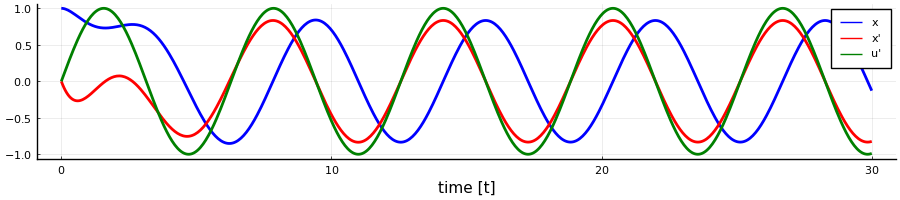

In [13]:
p100 = plot(solution.t, [k[1] for k in solution.u], color="blue", linewidth=2, xlabel="", label="x", size=(900,200))
plot!(solution.t, [k[2] for k in solution.u], color="red", linewidth=2, xlabel="time [t]", label="x'")
plot!(solution.t, U.(solution.t), color="green", linewidth=2, xlabel="time [t]", label="u'")

In [6]:
savefig(p100, "figures/contime-ddharm-osc.png")

## Discretization

Using Euler's method, we obtain the following discrete-time system:

$$\begin{align}
x_k =&\ \theta_1 x_{k-1} + \theta_2 x_{k-1}^3 + \theta_3 x_{k-2} + \eta u_k \, .
\end{align}$$

where the coefficients $\theta = (\theta_1, \dots, \theta_3)$ and $\eta$ are nonlinear combinations of the physical parameters (i.e. mass, damping and stiffness). 

In [ ]:
# Substituted variables
θ1 = (2*m + c - a)/(m + d)
\theta1
θ2 = -b/(m + c)
θ3 = -m/(m + c)
θ_true = [θ1, θ2, θ3]
η_true = 1/(m + c)

# Pack substituted variables
subs_params = (θ_true..., η_true, ζ_true, ξ_true);

In [ ]:
function sim_sys(input, state, params)
   "Simulate dynamic system"
    
    # Unpack state
    x_kmin1, x_kmin2 = state
    
    # Unpack system parameters
    θ1,θ2,θ3,η,ζ,ξ = sys_params
    
    # Draw noises
    w_k = sqrt(inv(ζ))*randn(1,)[1]
    v_k = sqrt(inv(ξ))*randn(1,)[1]
    
    # State transition
    x_k = θ1*x_kmin1 + θ2*x_kmin1^3 + θ3*x_kmin2 + η*input + w_k
    
    # Generate observation
    y_k = x_k + v_k
    
    return y_k, x_k    
end;

In [ ]:
# Test simulation environment

# Time
T = 400
TT = 200

# Input signal
input = [sin.((1:TT)./ (6*π)); zeros(T-TT,)]

# Preallocate arrays
states = zeros(T,)
output = zeros(T,)

# Initial states
states[1] = 1.
states[2] = 1.

for k = 3:T 
    # Simulate output and true state based on input and previous states
    output[k], states[k] = sim_sys(input[k], states[[k-1, k-2]], sys_params)
end

## Model

We cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{k} \\ x_{k-1} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{k-1} \\ x_{k-2} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{s} g(\theta, z_{k-1}) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

with $g(\theta, z_{k-1}) = \theta_1 x_{k-1} + \theta_2 x_{k-2}$ and $\tilde{w}_k \sim \mathcal{N}(0, \zeta^{-1})$. The system is now a nonlinear autoregressive process:

$$z_k = f(\theta, z_{k-1}, \eta, u_k) + \tilde{w}_k$$

where $f(\theta, z_{k-1}, \eta, u_k) = S z_{k-1} + s g(\theta, z_{k-1}) + s \eta u_k$.

### Likelihood

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_k \sim&\ \mathcal{N}(f(\theta, z_{k-1}, \eta, u_k), V(\zeta)) \\
y_k \sim&\ \mathcal{N}(s^{\top} z_k, \xi^{-1}) \, ,
\end{align}$$

where $V(\zeta) = \begin{bmatrix} \zeta^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W(\zeta) = V(\zeta)^{-1} = \begin{bmatrix} \zeta & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion;

$$ g(\theta, x) = g(m_{\theta}, m_x) + J_{x}(m_{\theta}, m_x)^{\top}(x - m_x) + J_{\theta}(m_{\theta}, m_x)^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and one could argue that the approximation is unnecessary. However, this form is more general and the first-order Taylor is exact anyway.

### Priors

We choose the following priors:

$$\begin{align}
p(\theta) = \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\zeta)= \text{Gamma}(a^{0}_\zeta, b^{0}_\zeta) \, , \quad
p(\xi)= \text{Gamma}(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \text{Normal}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \text{Normal}(m_{\eta}, v_{\eta}) \ , \quad  
q(\zeta)= \text{Gamma}(a_\zeta, b_\zeta) \, , \quad
q(\xi)= \text{Gamma}(a_\xi, b_\xi) \, .
\end{align}$$

### Variational free energy

#TODO

---

We implemented the model in [ForneyLab.jl](hkps://github.com/biaslab/ForneyLab.jl) with a custom node called Nonlinear Latent Autoregressive eXogenous input (NLARX) model.

In [ ]:
using Optim
using ForneyLab
using NLARX

In [ ]:
include("util.jl");

In [ ]:
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precisions
@RV ζ ~ Gamma(placeholder(:a_ζ), placeholder(:b_ζ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV x ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:w_x, dims=(2, 2)), id=:x_k)

# Nonlinearity
g(θ, z) = θ[1]*z[1] + θ[2]*z[1]^3 + θ[3]*z[2]

# Autoregressive node
@RV z ~ NLatentAutoregressiveX(θ, x, η, placeholder(:u), ζ, g=g, id=:z_k)

# Specify likelihood
@RV y ~ GaussianMeanPrecision(dot([1. , 0.], z), ξ, id=:y_k)
placeholder(y, :y);

# Specify recognition model
q = PosteriorFactorization(z, x, θ, η, ζ, ξ, ids=[:z, :x, :θ, :η, :ζ, :ξ])

# Specify and compile message passing algorithm
algo = messagePassingAlgorithm([z, x, θ, η, ζ, ξ], q, free_energy=true)
eval(Meta.parse(algorithmSourceCode(algo, free_energy=true)));

### Infer parameters on training data

In [ ]:
# Time horizon
T = 200

# Goal state (mean and std dev)
goal_state = [.5, 1e-6]

# Planning horizon
plan_horizon = 3

# Number of variational updates
num_iterations = 10

# Preallocation
inputs = zeros(T,)
states = zeros(T,)
outputs = zeros(T,)

# Initialize marginal and data dicts
data = Dict()
marginals = Dict()

# Initialize free energy tracking array
F = zeros(T, num_iterations)

# Initialize arrays of parameterizations
state_estimates = (zeros(T,), zeros(T,))

# Initialize arrays of parameterizations
params_x = (zeros(2,T), .1 .*repeat(eye(2), outer=(1,1,T)))
params_z = (zeros(2,T), .1 .*repeat(eye(2), outer=(1,1,T)))
params_θ = (zeros(3,T), .1 .*repeat(eye(3), outer=(1,1,T)))
params_η = (ones(1,T), .1 .*ones(1,T))
params_ζ = (1e2*ones(1,T), 1e0*ones(1,T))
params_ξ = (1e4*ones(1,T), 1e0*ones(1,T))

@showprogress for k = 3:T
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k-1], states[[k-1,k-2]], sys_params)
    
    "Identification"
    
    # Initialize marginals
    marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,k-1], w=params_x[2][:,:,k-1])
    marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,k-1], w=params_z[2][:,:,k-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,k-1], w=params_θ[2][:,:,k-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,k-1], w=params_η[2][1,k-1])
    marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=params_ζ[1][1,k-1], b=params_ζ[2][1,k-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,k-1], b=params_ξ[2][1,k-1])
    
    data = Dict(:y => outputs[k],
                :u => inputs[k],
                :m_x => params_z[1][:,k-1],
                :w_x => params_z[2][:,:,k-1],
                :m_θ => params_θ[1][:,k-1],
                :w_θ => params_θ[2][:,:,k-1],
                :m_η => params_η[1][1,k-1],
                :w_η => params_η[2][1,k-1],
                :a_ζ => params_ζ[1][1,k-1],
                :b_ζ => params_ζ[2][1,k-1],
                :a_ξ => params_ξ[1][1,k-1],
                :b_ξ => params_ξ[2][1,k-1])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz!(data, marginals)
        stepx!(data, marginals)
        
        # Update noise precisions
        stepζ!(data, marginals)
        stepξ!(data, marginals)
        
        # Compute free energy
        F[k,ii] = freeEnergy(data, marginals)
        
    end    

    "Bookkeeping"
    
    # Store current parameterizations of marginals
    params_x[1][:,k] = umean(marginals[:x])
    params_x[2][:,:,k] = marginals[:x].params[:w]
    params_z[1][:,k] = umean(marginals[:z])
    params_z[2][:,:,k] = marginals[:z].params[:w]
    params_θ[1][:,k] = umean(marginals[:θ])
    params_θ[2][:,:,k] = marginals[:θ].params[:w]
    params_η[1][1,k] = umean(marginals[:η])
    params_η[2][1,k] = marginals[:η].params[:w]
    params_ζ[1][1,k] = marginals[:ζ].params[:a]
    params_ζ[2][1,k] = marginals[:ζ].params[:b]
    params_ξ[1][1,k] = marginals[:ξ].params[:a]
    params_ξ[2][1,k] = marginals[:ξ].params[:b]
    
    # Store state estimates
    state_estimates[1][k] = params_z[1][1,k]
    state_estimates[2][k] = sqrt(inv(params_z[2][1,1,k]))
    
    "Control"
    
    # Pack parameters estimated by model
    model_params = (params_θ[1][:,k], params_η[1][1,k], params_ζ[1][k]/params_ζ[2][k], params_ξ[1][k]/params_ξ[2][k])
#     model_params = (umean(marginals[:θ]), umean(marginals[:η]), umean(marginals[:ζ]), umean(marginals[:ξ]))
    
    # Previous state
    state_kmin1 = [params_z[1][:,k], params_z[2][:,:,k]]
    
    # Objective function
    G(π) = EFE(π, state_kmin1, goal_state, model_params, g, order=2, time_horizon=plan_horizon)

    # Miminimize EFE
    results = optimize(G, -1, 1, rand(plan_horizon,), Fminbox(LBFGS()), Optim.Options(iterations=1000); autodiff=:forward)

    # Only execute first action in policy
    inputs[k] = Optim.minimizer(results)[1]
# 
end

In [ ]:
p1 = plot(3:T, inputs[3:T], color="red", label="inputs")
p2 = plot(3:T, outputs[3:T], color="blue", label="outputs")
# plot!(3:T, state_estimates[1][3:T], color="purple", label="inferred")
# plot!(3:T, state_estimates[1], ribbon=[state_estimates[2], state_estimates[2]], color="purple", label="")
plot!(3:T, goal_state[1]*ones(T-2,), color="green", label="goal state")
plot(p1, p2, layout=(2,1), size=(900,400))

In [ ]:
# Scatter FE during training
p24 = plot(1:T, F[:,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time", size=(900,300))

In [ ]:
# Scatter FE during training
p34 = plot(mean(F, dims=1)', color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Average free energy over iterations", size=(900,300))

### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [ ]:
# Time horizon
T_val = 1000

# Input signal
input_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val] 
# input_val = sin.((1:T_val) ./ (6*π))

# Preallocate arrays
states_val = zeros(T_val,)
output_val = zeros(T_val,)

for k = 4:T_val
    output_val[k], states_val[k] = sim_sys(input_val[k], [states_val[k-1], states_val[k-2]], sys_params)
end

In [ ]:
# Write to file


In [ ]:
# Prediction graph
graph2 = FactorGraph()

# Autoregressive node
@RV z_pred ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), placeholder(:z_tmin1, dims=(2,)), placeholder(:η), placeholder(:u_t), placeholder(:ζ), g=g, id=:z_pred_t)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred, ids=[:z_pred])
algo2 = messagePassingAlgorithm([z_pred], q2, free_energy=true)
source_code2 = algorithmSourceCode(algo2, free_energy=true)
eval(Meta.parse(source_code2));
# println(source_code2)

In [ ]:
# Initialize free energy tracking array
free_energy_pred = zeros(T_val, num_iterations)

# Initialize future state arrays
params_preds = (zeros(2, T_val), repeat(.1 .*float(eye(2)), outer=(1,1,T_val)))

# Start simulation with known output
params_preds[1][1,2] = output_val[2]
params_preds[1][2,2] = output_val[1]

@showprogress for k = 3:T_val

    # Initialize marginals
    marginals[:z_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,k], w=params_preds[2][:,:,k])

    # Clamp data
    data = Dict(:u_t => input_val[k],
                :z_tmin1 => params_preds[1][:,k-1],
                :θ => params_θ[1][:,end],
                :η => params_η[1][end],
                :ζ => params_ζ[1][end]/params_ζ[2][end])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        # Make prediction
        stepz_pred!(data, marginals)

        # Compute free energy
        free_energy_pred[k, i] = freeEnergy(data, marginals)
    end

    # Store current parameterizations of marginals
    params_preds[1][:,k] = ForneyLab.unsafeMean(marginals[:z_pred])
    params_preds[2][:,:,k] = marginals[:z_pred].params[:w]

end

### Visualize results

In [ ]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:]))

# Plot predictions
p23 = scatter(1:T_val, output_val, label="observations", xlabel="time (t)", color="black")
plot!(1:T_val, predictions_mean, ribbon=[predictions_std, predictions_std], label="predictions", color="red")

In [ ]:
Plots.savefig(p23, "figures/simulation_error.png")

In [ ]:
# Compute prediction error
sq_pred_error = (predictions_mean[2:end] .- output_val[2:end]).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

In [ ]:
Plots.savefig(p24, "figures/pred-errors.png")

In [ ]:
# Scatter FE during validation
p24 = plot(1:T_val, free_energy_pred[:,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy of predictions")